# Visualization

## 20211127_224624_μ1_n4.csv
```
trial_count = 100
agent_count = 10^3
generations = 10^3

network_type_list = [:scale_free_4]
hop_game_list = [1, 2, 3, 4, 5]
hop_learning_list = [1, 2, 3, 4, 5]
n_game_list = [4]
n_learning_list = [4]
b_list = [2.0, 3.0, 4.0, 5.0]
μ = 0.01
```

## ToDo
```
trial_count = 1
agent_count = 10^2
generations = 10^2

network_type_list = [:scale_free_4]
hop_game_list = [1]
hop_learning_list = [1, 2, 5]
n_game_list = [4]
n_learning_list = [4]
b_list = [2.0, 3.0]
μ = 0.00
```

In [4]:
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class Simulation:
    def __init__(self, file_name):
        self.file_name = file_name
        self.df = pd.read_csv(file_name, header=1, names=['network_type', 'hop_game', 'hop_learning', 'n_game', 'n_learning', 'b', 'trial', 'step', 'cooperator_rate'])
        self.last_step_df = self.df[self.df.step == max(self.df.step)]

        self.network_type_list = sorted(set(self.df.network_type))
        self.hop_game_list = sorted(set(self.df.hop_game))
        self.hop_learning_list = sorted(set(self.df.hop_learning))
        self.n_game_list = sorted(set(self.df.n_game))
        self.n_learning_list = sorted(set(self.df.n_learning))
        self.b_list = sorted(set(self.df.b))

    def __transform(self, _df: pd.DataFrame, b: float, n_game: float, n_learning: float, network_type: str) -> pd.DataFrame:
        _df = _df[(_df.b == b) & (_df.n_game == n_game) & (_df.n_learning == n_learning) & (_df.network_type == network_type)] \
            .groupby(['hop_game', 'hop_learning']) \
            .agg({'cooperator_rate': np.mean})
        _df = pd \
            .pivot_table(data=_df, values='cooperator_rate', columns='hop_learning', index='hop_game', aggfunc=np.mean) \
            .sort_index(level=0, ascending=False, inplace=False)
        return _df

    def draw_heatmaps(self):
        for b in self.b_list:
            for network_type in self.network_type_list:
                fig, axes = plt.subplots(nrows=len(self.n_game_list), ncols=len(self.n_learning_list), figsize=(15, 15), sharex=True, sharey=True)
                fig.suptitle('b = {}, network_type = {}'.format(b, network_type), fontsize=15)

                for _y, n_game in enumerate(self.n_game_list):
                    for _x, n_learning in enumerate(self.n_learning_list):
                        _df = self.__transform(self.last_step_df, b, n_game, n_learning, network_type)
                        axes[_x, _y].set(title = 'n_learning = {}, n_game = {}'.format(n_learning, n_game))
                        sns.heatmap(_df, annot=True, fmt='.2f', cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, ax=axes[_x, _y])
                        plt.savefig('img/{}_{}.png'.format(b, network_type), dpi = 300)

    def draw_two_heatmaps(self, b: float):
        # ToDo: modify to last 200 steps average
        _df_b = self.last_step_df[self.last_step_df.b == b]

        assert len(self.n_game_list) == 1, self.n_game_list
        assert len(self.n_learning_list) == 1, self.n_learning_list
        assert len(self.network_type_list) == 2, self.network_type_list

        _n_game = self.n_game_list[0]
        _n_learning = self.n_learning_list[0]

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        fig.suptitle('b = {}, n_game = {}, n_learning = {}'.format(b, _n_game, _n_learning), fontsize=15)

        for _x, _network_type in enumerate(self.network_type_list):
            _df = self.__transform(_df_b, b, _n_game, _n_learning, _network_type)
            axes[_x].set(title = '{}'.format(_network_type))
            sns.heatmap(_df, annot=True, fmt='.2f', cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, ax=axes[_x])

        # plt.savefig('img/{}_{}_{}.png'.format(_b, _n_game, _n_learning), dpi = 300)

    def draw_heatmaps_a_network(self, network_type: str):
        _df = self.df[(self.df.network_type == network_type) & (self.df.step >= 800)]

        assert len(self.n_game_list) == 1, self.n_game_list
        assert len(self.n_learning_list) == 1, self.n_learning_list

        _n_game = self.n_game_list[0]
        _n_learning = self.n_learning_list[0]

        fig, axes = plt.subplots(nrows=1, ncols=len(self.b_list), figsize=(20, 5))
        fig.suptitle('Population frequency of cooperators on scale-free network (n_game = {}, n_learning = {}, step = 800~1000)'.format(_n_game, _n_learning), fontsize=15)

        for _x, _b in enumerate(self.b_list):
            __df = self.__transform(_df, _b, _n_game, _n_learning, network_type)
            axes[_x].set(title = 'b = {}'.format(_b))
            sns.heatmap(__df, annot=True, fmt='.2f', cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, ax=axes[_x])

    def line_graph_santos(self):
        fig, axes = plt.subplots(nrows=len(self.n_game_list), ncols=len(self.n_learning_list), figsize=(15, 15))
        fig.suptitle('regular graph v.s. scale free network (hop = 1)', fontsize=15)

        for y, n_game in enumerate(self.n_game_list):
            for x, n_learning in enumerate(self.n_learning_list):
                _df = self.last_step_df
                _df = _df[(_df.hop_game == 1) & (_df.hop_learning == 1) & (_df.n_game == n_game) & (_df.n_learning == n_learning)]
                axes[x, y].set(title = 'n_game = {}, n_learning={}'.format(n_game, n_learning))
                sns.lineplot(data=_df, x='b', y='cooperator_rate', hue='network_type', ax=axes[x, y])

    def line_graph(self):
        assert len(self.n_game_list) == 1
        assert len(self.n_learning_list) == 1

        _n_game = self.n_game_list[0]
        _n_learning = self.n_learning_list[0]

        for _b in self.b_list:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
            fig.suptitle('scale_free, n_game = {}, n_learning = {}, b = {}'.format(_n_game, _n_learning, _b), fontsize=15)

            _df_hop_learning = self.df[(self.df.hop_game == 1) & (self.df.network_type == 'scale_free') & (self.df.b == _b)]
            axes[0].set(title = 'hop_game = 1')
            palette = sns.color_palette('hls', len(self.hop_learning_list))
            sns.lineplot(data=_df_hop_learning, x='step', y='cooperator_rate', hue='hop_learning', palette=palette, ax=axes[0])

            _df_hop_game = self.df[(self.df.hop_learning == 1) & (self.df.network_type == 'scale_free') & (self.df.b == _b)]
            axes[1].set(title = 'hop_learning = 1')
            palette = sns.color_palette('hls', len(self.hop_game_list))
            sns.lineplot(data=_df_hop_game, x='step', y='cooperator_rate', hue='hop_game', palette=palette, ax=axes[1])

    def line_graph_scale_free_hop_game_1(self, network_type:str):
        assert len(self.n_game_list) == 1
        assert len(self.n_learning_list) == 1

        _n_game = self.n_game_list[0]
        _n_learning = self.n_learning_list[0]

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        fig.suptitle('scale_free (hop_game = 1, n_game = {}, n_learning = {})'.format(_n_game, _n_learning), fontsize=15)

        for x, _b in enumerate([2, 3]):  # self.b_list

            _df_hop_learning = self.df[(self.df.hop_game == 1) & (self.df.network_type == network_type) & (self.df.b == _b)]
            axes[x].set_title('b = {}'.format(_b))
            axes[x].set_xlim(0, 1000)
            axes[x].set_ylim(0, 1)
            axes[x].set_ylabel('Population frequency of cooperators')
            palette = sns.color_palette('hls', len(self.hop_learning_list))
            sns.lineplot(data=_df_hop_learning, x='step', y='cooperator_rate', hue='hop_learning', palette=palette, ax=axes[x])

In [8]:
sim_μ0 = Simulation("data/20211126_074228_μ0_n4.csv")
sim_μ1 = Simulation("data/20211127_224624_μ1_n4.csv")
sim_sf68 = Simulation("data/20211201_164012_sf68.csv")

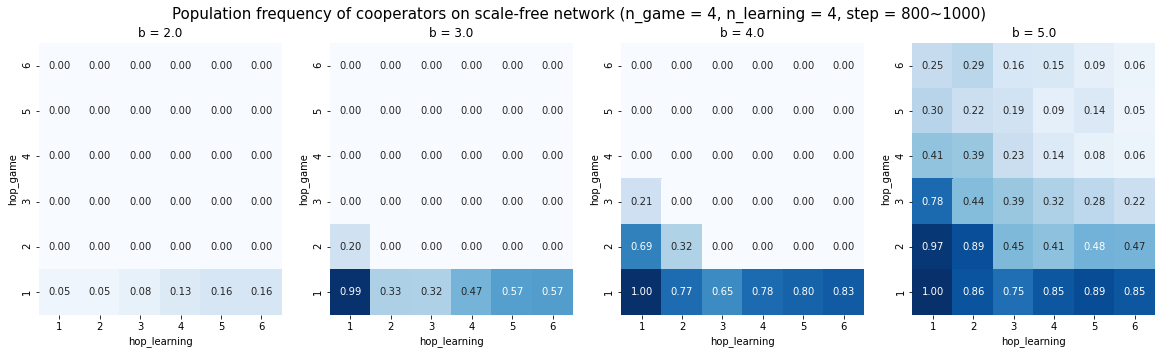

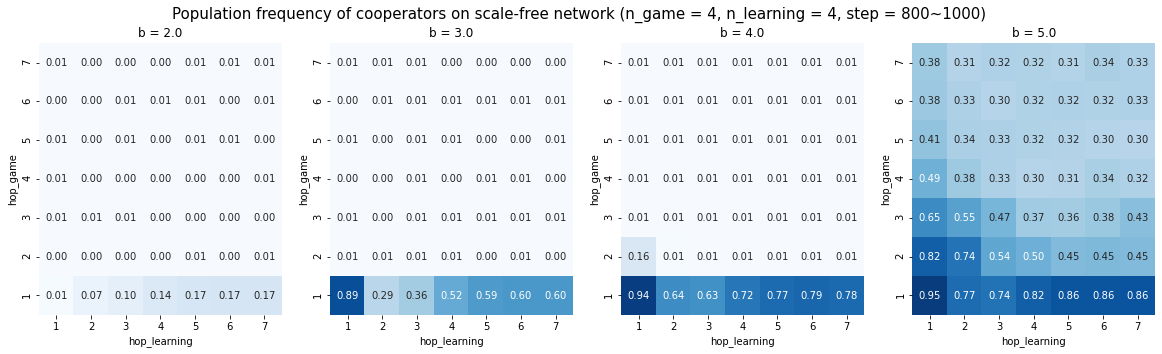

In [7]:
sim_μ0.draw_heatmaps_a_network('scale_free')
sim_μ1.draw_heatmaps_a_network('scale_free')

(1, 1)はサントスで説明できる。(7, 1)はスキールフリーとウェルミックスのマルチプレックスネットワークで説明できる。

# 可視化して、b=2のときの (1, 1) と (1, 5) の違いを見る。b=3のときの (1, 1) と (2, 1) の違いを見る。

In [8]:
# sim_sf68.draw_heatmaps_a_network('scale_free_6')
# sim_sf68.draw_heatmaps_a_network('scale_free_8')

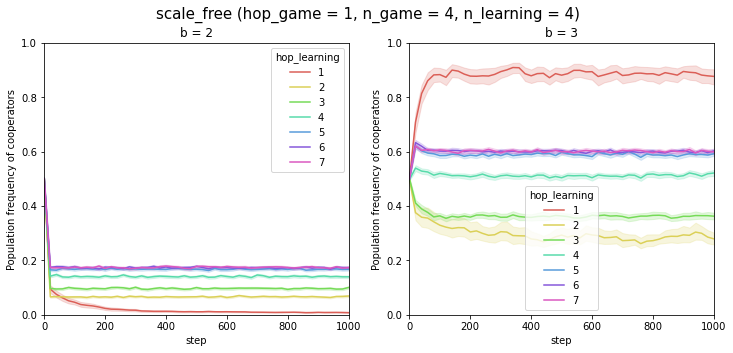

In [9]:
# sim_μ0.line_graph_scale_free_hop_game_1()
sim_μ1.line_graph_scale_free_hop_game_1('scale_free')

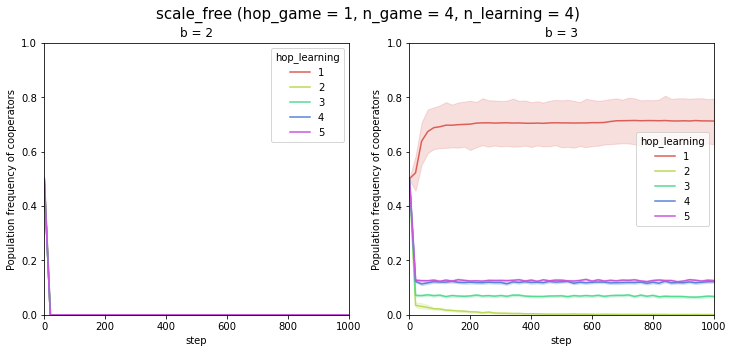

In [51]:
sim_sf68.line_graph_scale_free_hop_game_1('scale_free_6')

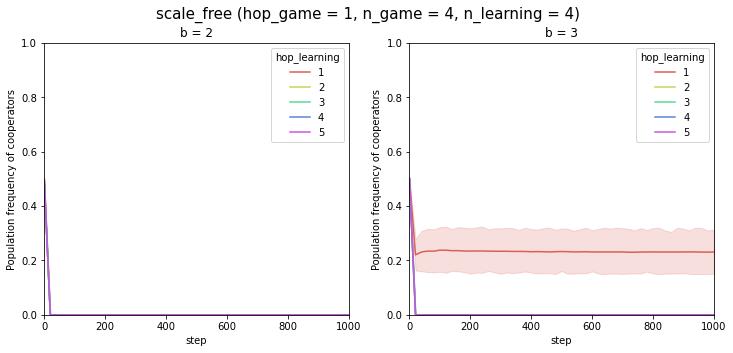

In [50]:
sim_sf68.line_graph_scale_free_hop_game_1('scale_free_8')

- 突然変異なしの場合も大差ない結果
- 分散も大きくないので省略

## Heatmap

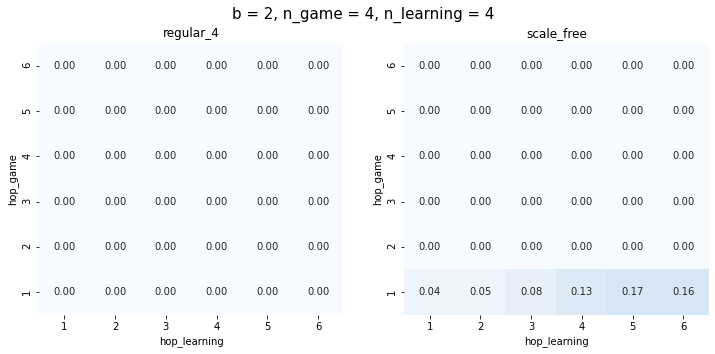

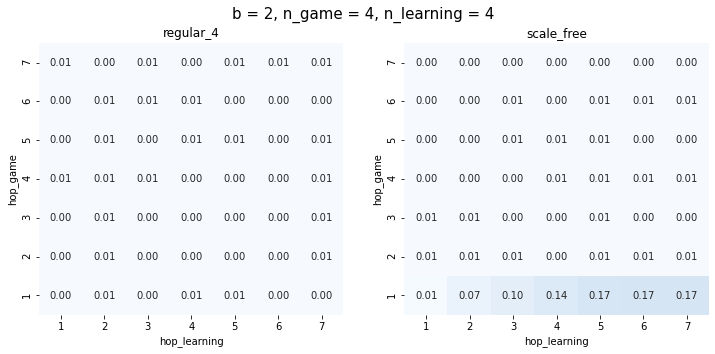

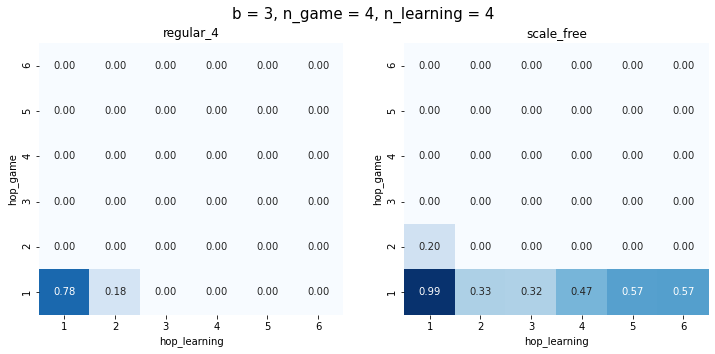

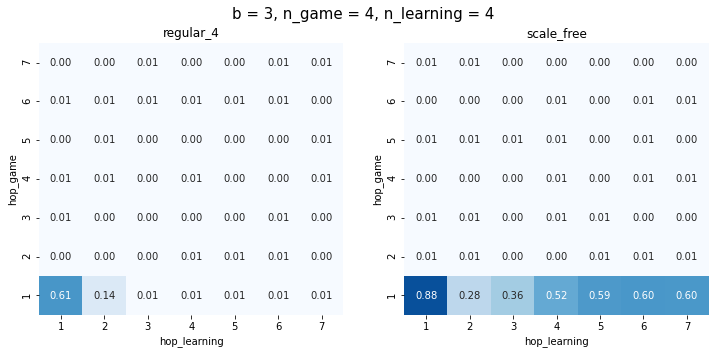

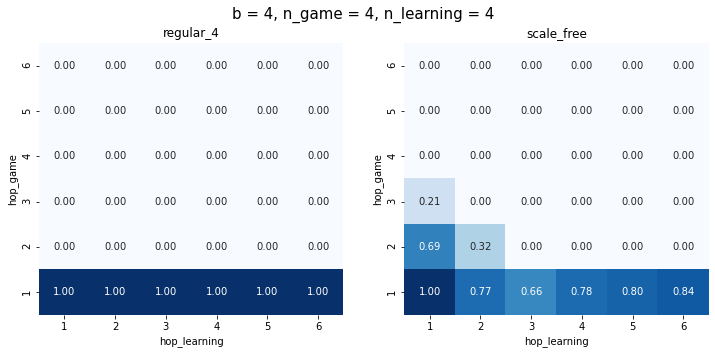

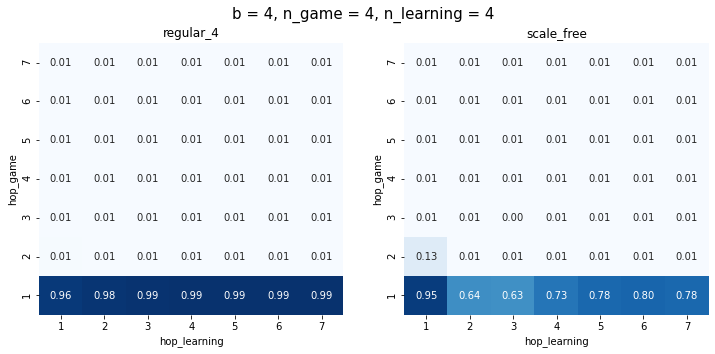

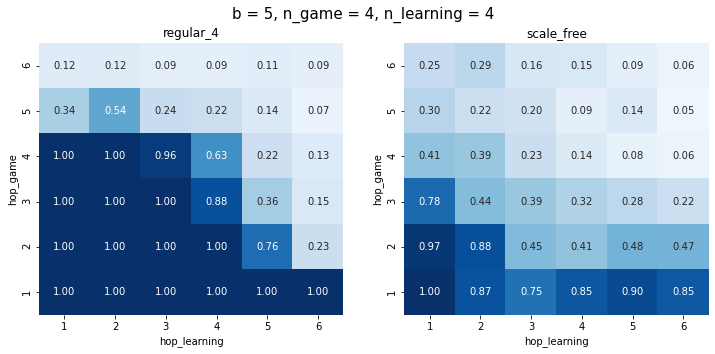

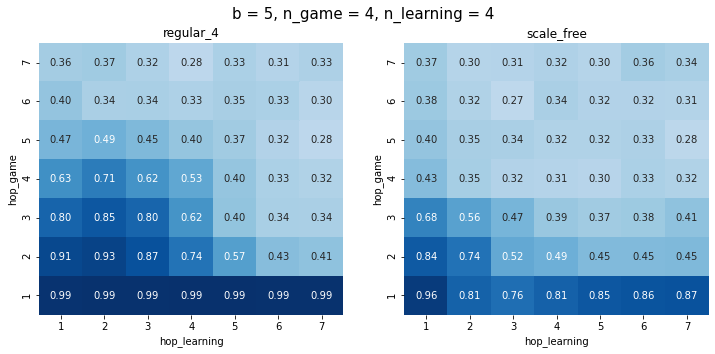

In [37]:
sim_μ0.draw_two_heatmaps(b=2)
sim_μ1.draw_two_heatmaps(b=2)

sim_μ0.draw_two_heatmaps(b=3)
sim_μ1.draw_two_heatmaps(b=3)

sim_μ0.draw_two_heatmaps(b=4)
sim_μ1.draw_two_heatmaps(b=4)

sim_μ0.draw_two_heatmaps(b=5)
sim_μ1.draw_two_heatmaps(b=5)

In [29]:
sim_all = Simulation("data/20211126_080844_trial=10_all.csv")

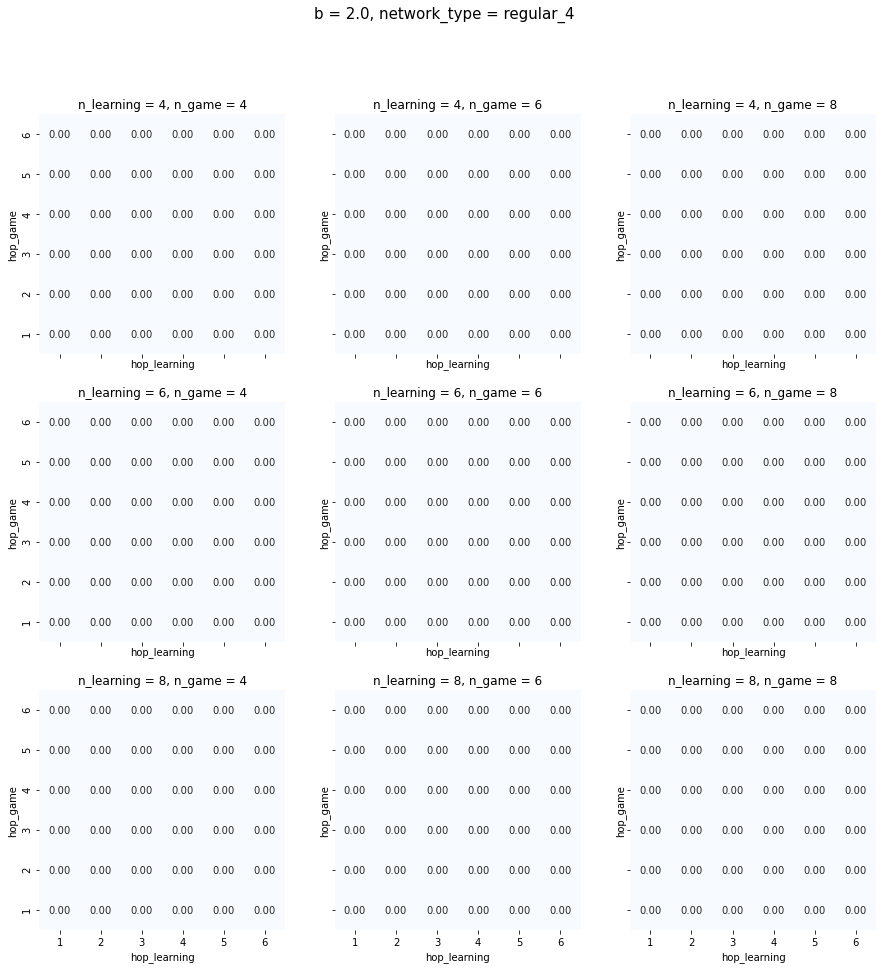

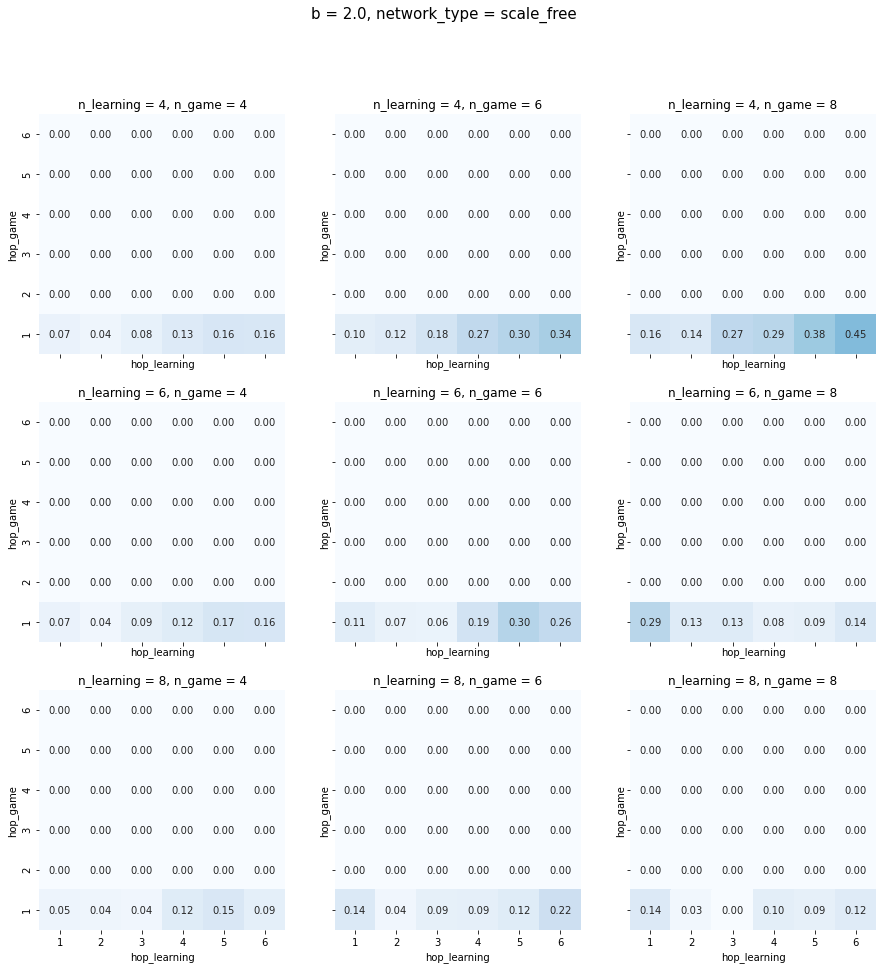

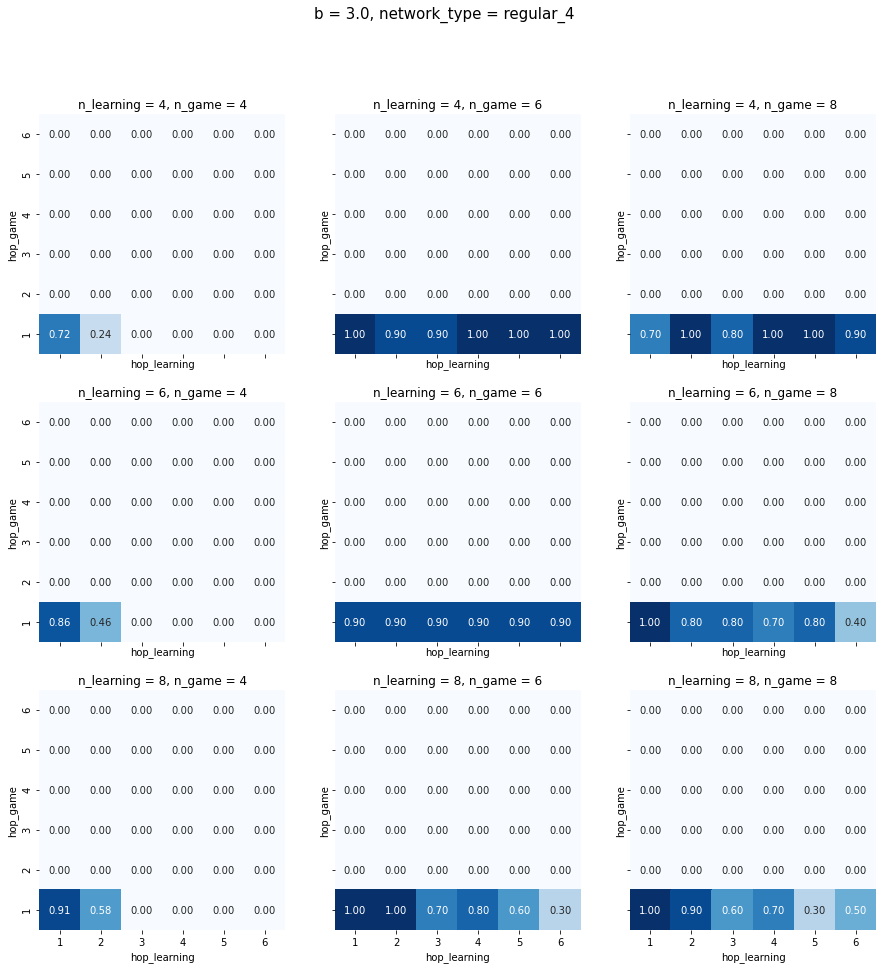

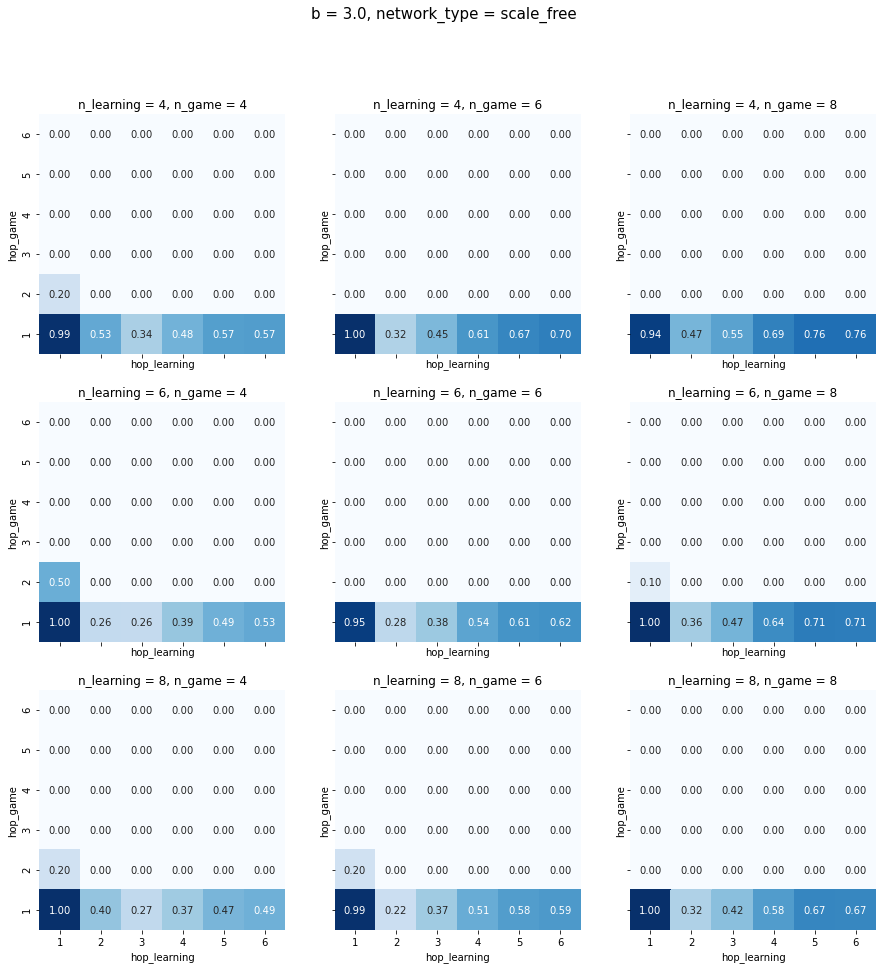

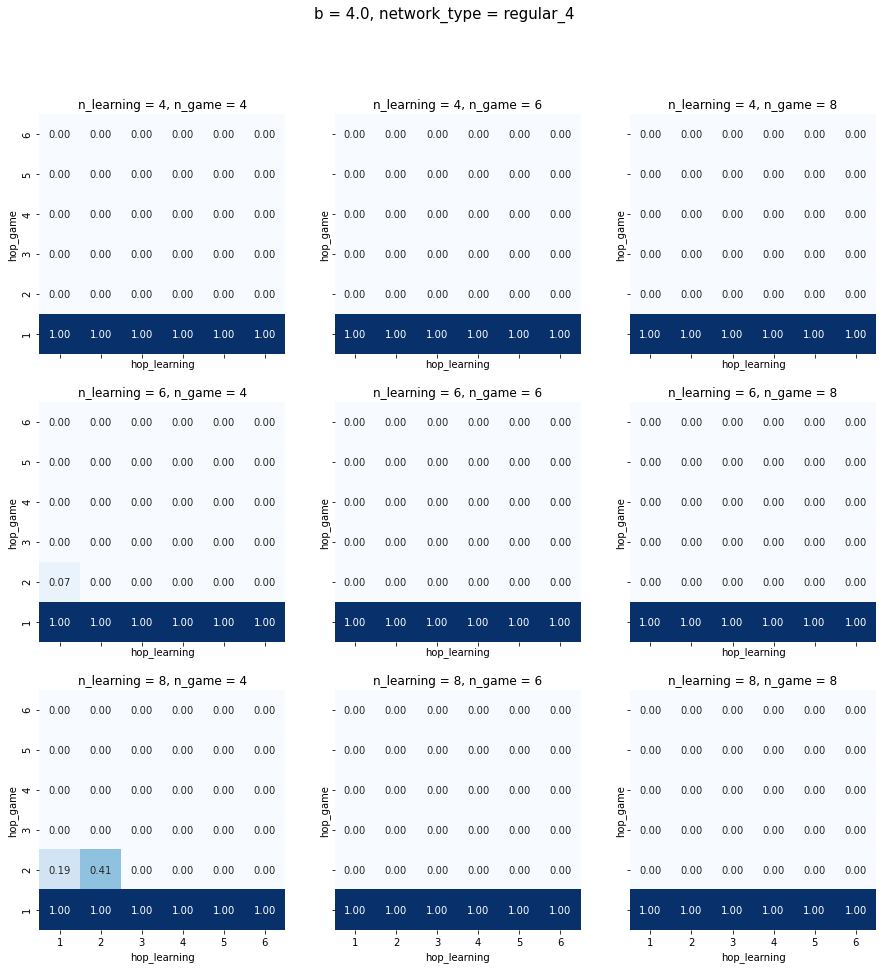

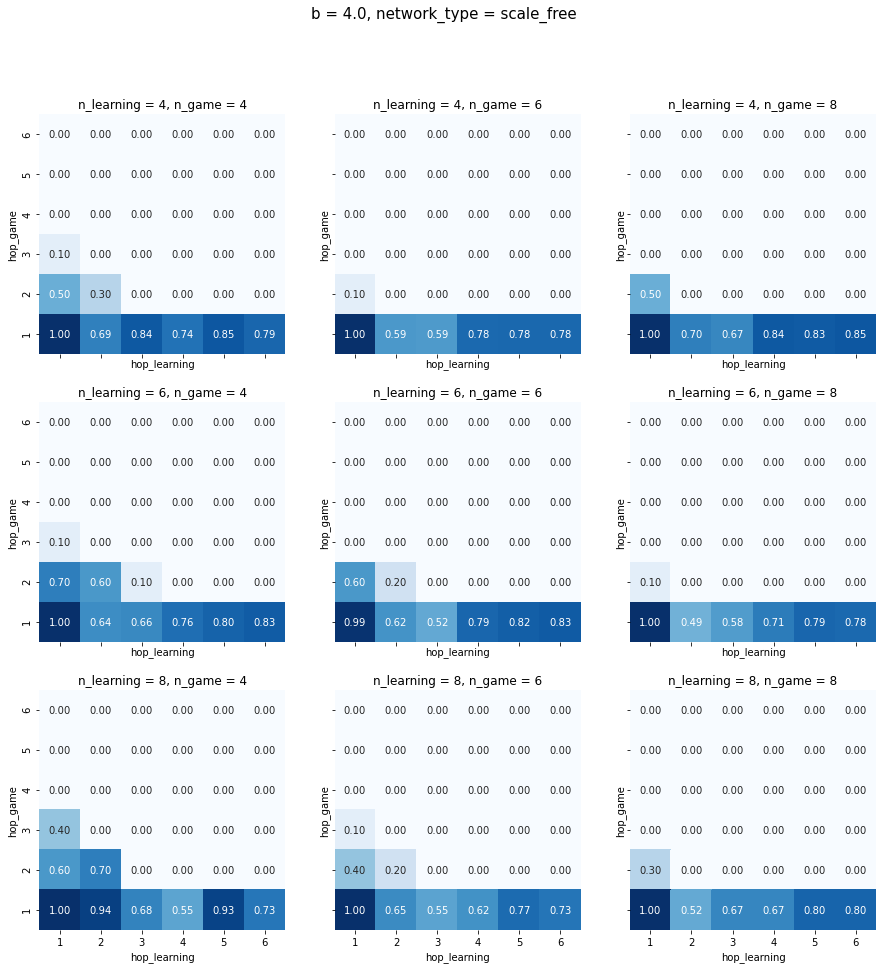

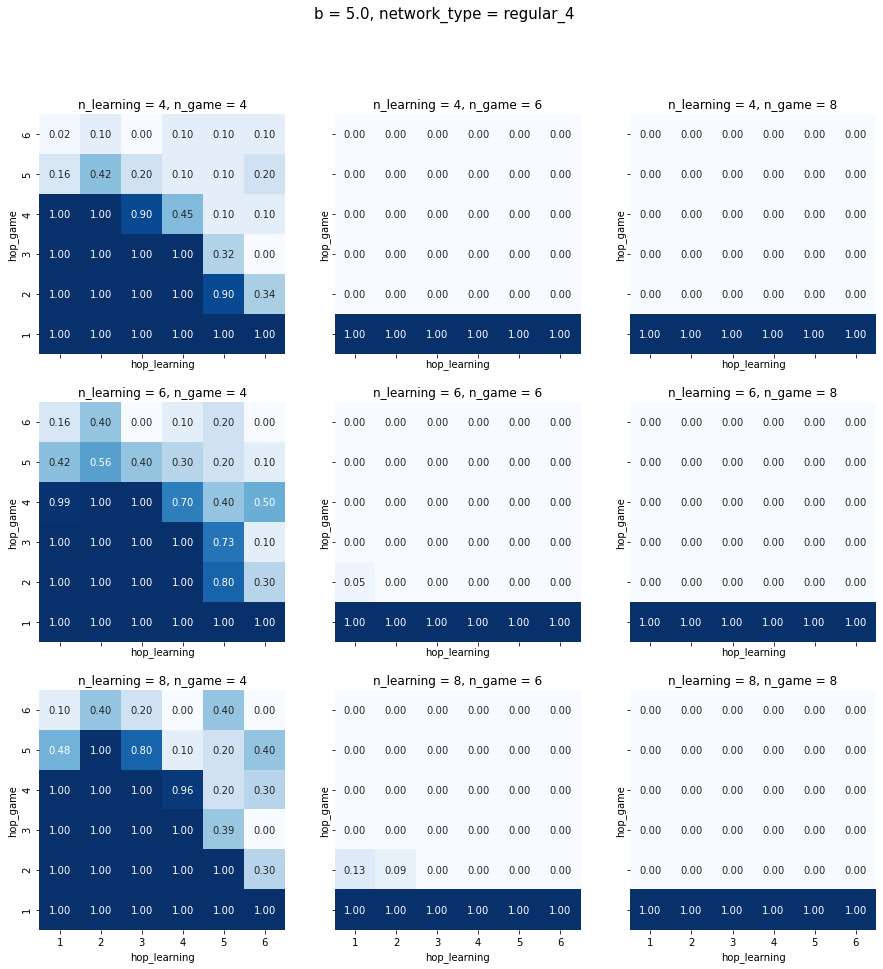

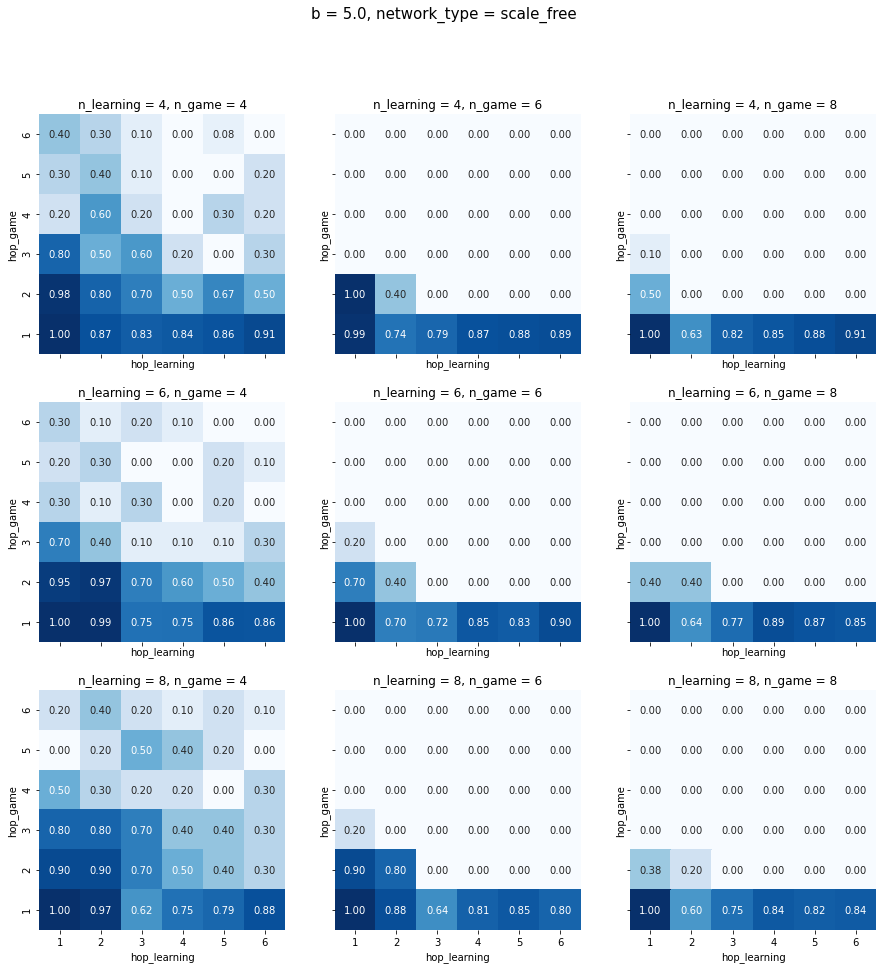

In [30]:
sim_all.draw_heatmaps()

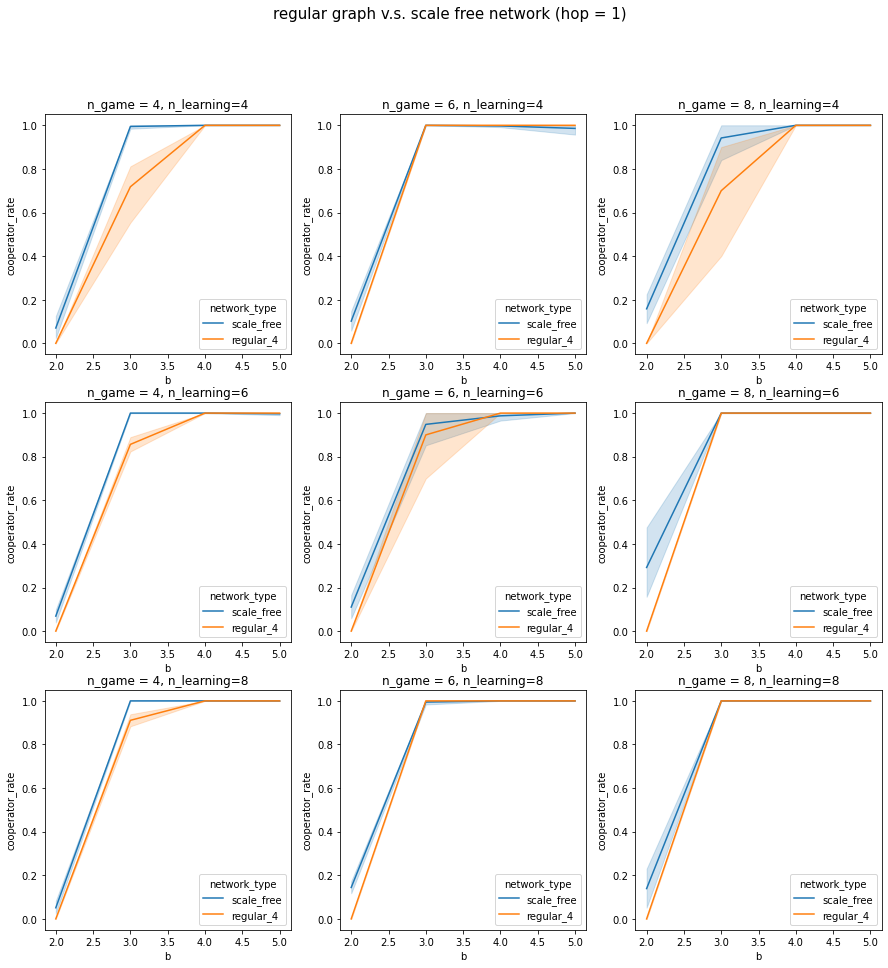

In [39]:
sim_all.line_graph_santos()

## Line graph

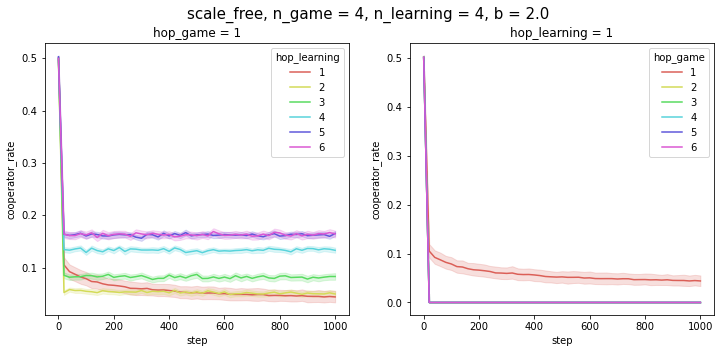

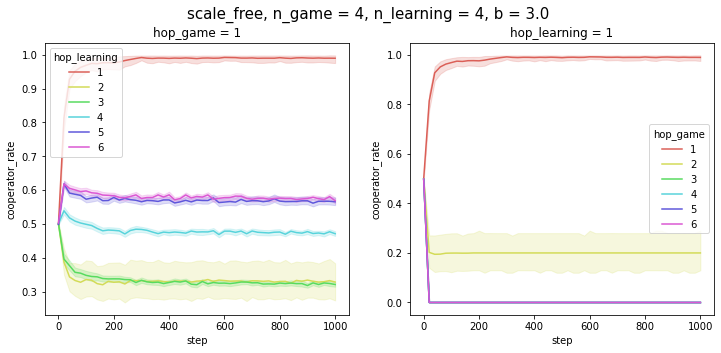

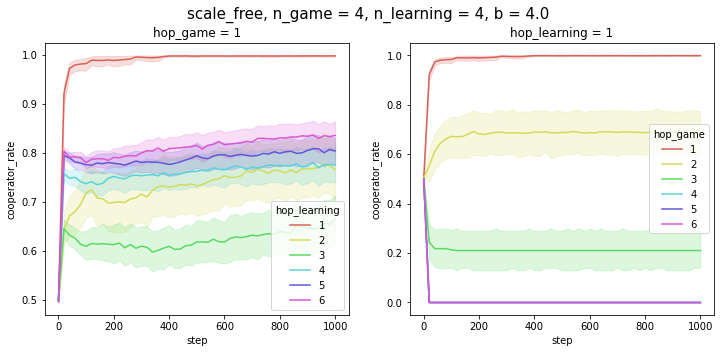

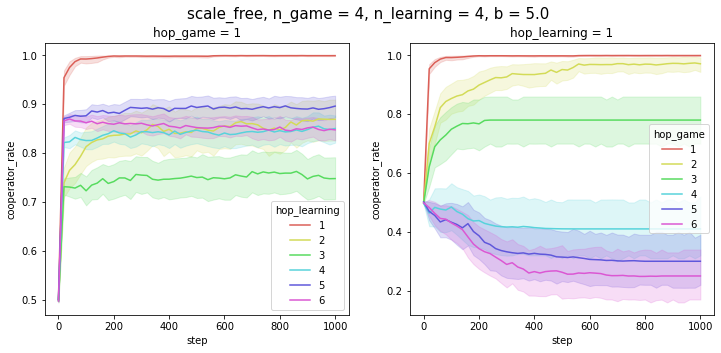

In [62]:
sim_μ0.line_graph()

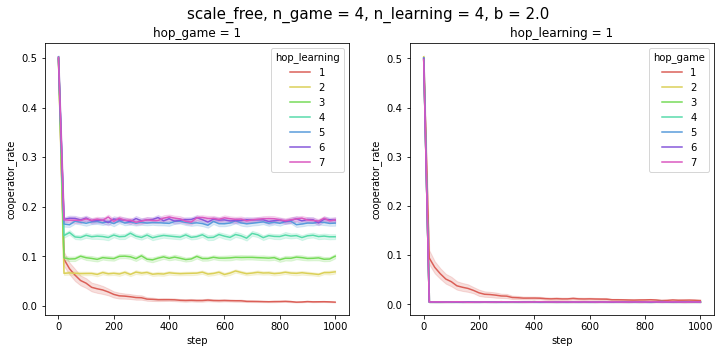

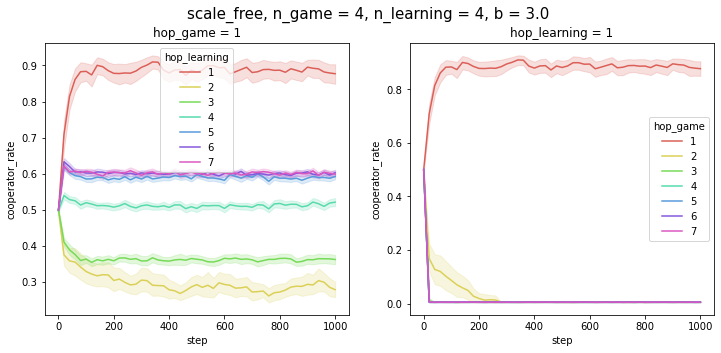

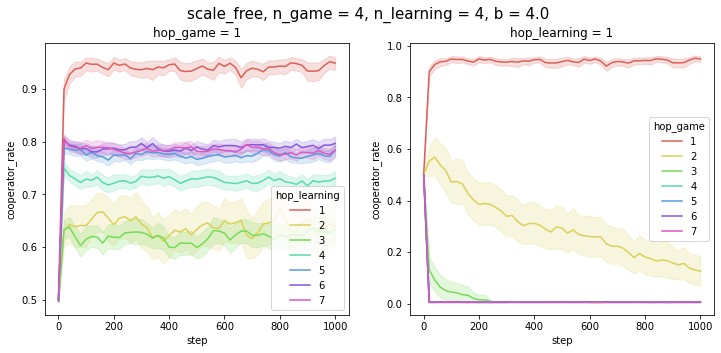

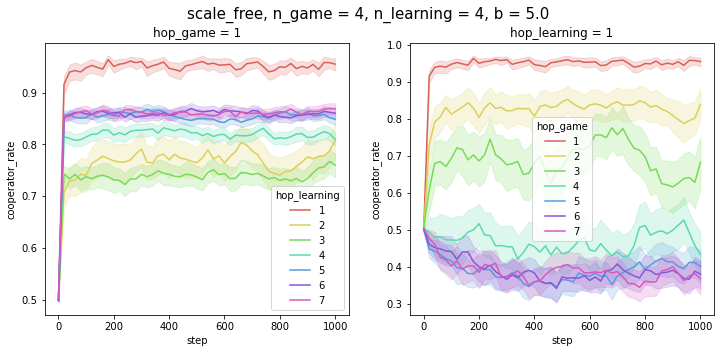

In [61]:
sim_μ1.line_graph()